In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from __future__ import division

plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
def gen_arma(ar=[], ma=[], N=1000, mu=0):
    
    p, q = map(len, [ar, ma])
    ar, ma = map(np.array, [ar[::-1], ma[::-1]])
    
    max_order = max(p, q)
    
    wn = np.random.normal(0, 1, N + max_order)
    ts = np.ones(N + max_order) * mu
    
    for i in range(N):
        
        idx = i + max_order
        ts[idx] = wn[idx] + np.dot(ts[idx - p:idx], ar) + np.dot(wn[idx - q:idx], ma)
    
    return ts[max_order:]

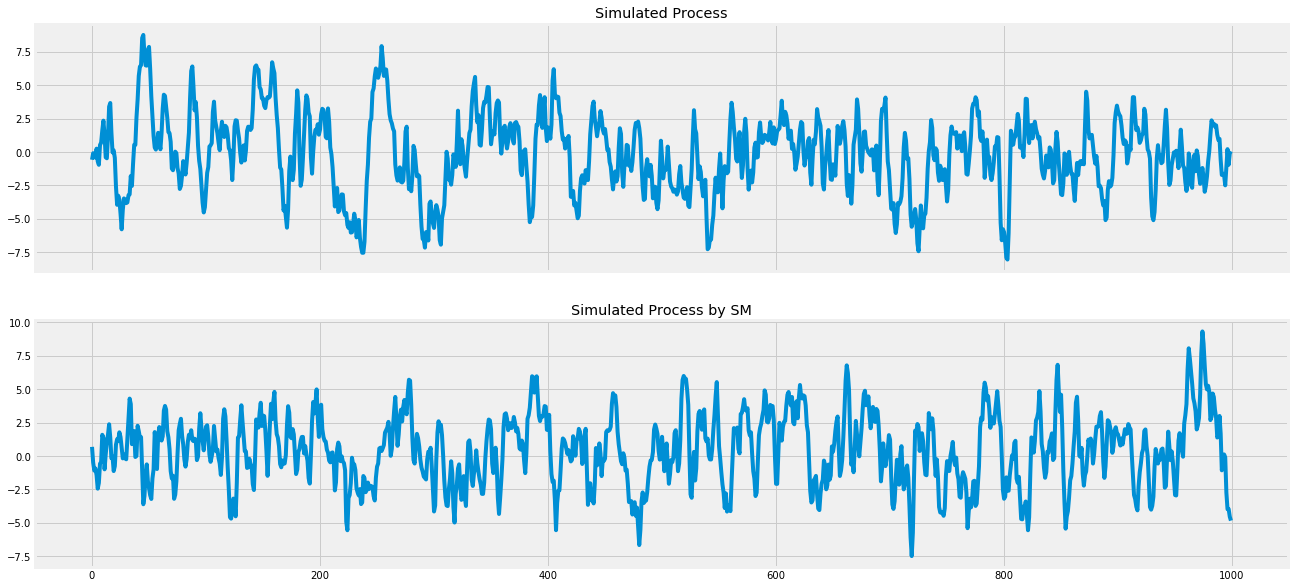

In [3]:
T = 1000
ar_coef = [0.8]
ma_coef = [0.7]

y_jc = gen_arma(ar_coef, ma_coef, T)
y_sm = sm.tsa.ArmaProcess(-np.array([-1] + ar_coef), [1] + ma_coef).generate_sample(T)

fig, ax = plt.subplots(2,1, sharex=True, figsize=(20,10))
ax[0].plot(range(T), y_jc)
ax[1].plot(range(T), y_sm)

ax[0].set_title('Simulated Process')
ax[1].set_title('Simulated Process by SM')

In [4]:
def OLS(Y, X, const=True):
    Y = np.array(Y)
    X = np.c_[np.ones(np.shape(Y)),np.array(X)] if const else np.array(X)
    
    cov = np.dot(np.transpose(X),Y)
    var = np.dot(np.transpose(X),X)
    
    b = np.dot(np.linalg.inv(var), cov)
    return b if b.shape!=(1,1) else float(b)

def AR_data_preprocess(TS, ar_lag=1):
    
    Y = np.array(TS[ar_lag:])
    Y = Y.reshape(len(Y),1)
    X = np.r_[map(lambda i: TS[ar_lag-i-1:-i-1], range(ar_lag))].T
    
    return Y, X

In [5]:
def get_IV_est(Y):
    
    y, x = AR_data_preprocess(Y, 2)
    z = x[:,1]
    x = x[:,0]   
    return float(z.T.dot(y) / z.T.dot(x))

def get_OLS_est(Y):
    
    y, X = AR_data_preprocess(Y, 1)
    return OLS(y, X, False)

In [6]:
num_of_est = 10000

estimate = map(lambda s: (get_OLS_est(s), get_IV_est(s)), \
               [gen_arma(ar_coef, ma_coef, T) for i in range(num_of_est)])
estimate_OLS = [e[0] for e in estimate]
estimate_IV = [e[1] for e in estimate]

Mean of phi: 0.896076841863
SD of phi: 0.010320297925


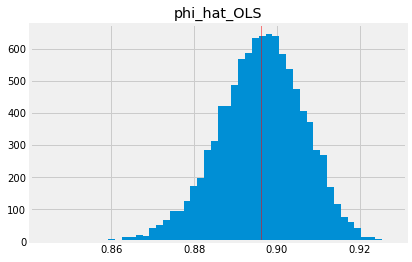

In [7]:
m_OLS = np.mean(estimate_OLS)

print 'Mean of phi:', m_OLS
print 'SD of phi:', np.std(estimate_OLS)
    
plt.hist(estimate_OLS, bins=50)
plt.axvline(m_OLS, linewidth=0.5, color='r')
plt.title('phi_hat_OLS')

Mean of phi: 0.798545843411
SD of phi: 0.0217330718144


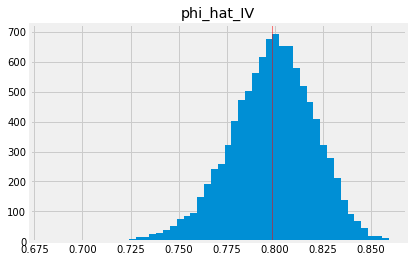

In [8]:
m_IV = np.mean(estimate_IV)

print 'Mean of phi:', m_IV
print 'SD of phi:', np.std(estimate_IV)
    
plt.hist(estimate_IV, bins=50)
plt.axvline(m_IV, linewidth=0.5, color='r')
plt.title('phi_hat_IV')

### Test with statsmodels

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1559.323
Method:                       css-mle   S.D. of innovations              1.150
Date:                Tue, 18 Apr 2017   AIC                           3122.646
Time:                        16:19:56   BIC                           3132.461
Sample:                             0   HQIC                          3126.376
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1.y        0.9163      0.013     73.124      0.000         0.892     0.941
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0914           +0.0000j            1.0914            0.0000
-----------------------------------------------------------------------------
"""

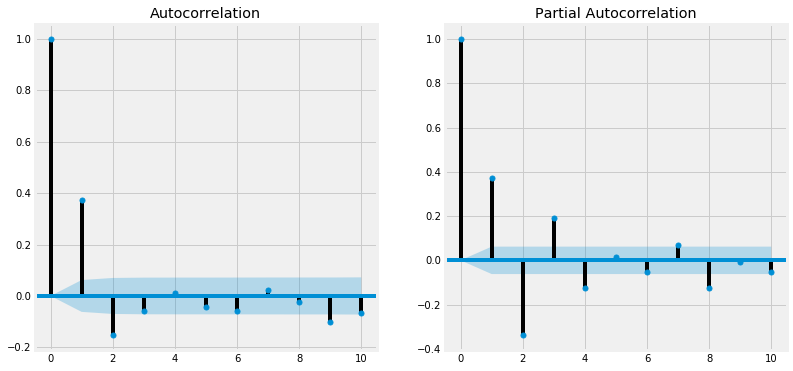

In [9]:
arma_model = sm.tsa.ARMA(y_jc, order=(1,0))

ests = arma_model.fit(maxiter=500, trend='nc')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sm.tsa.graphics.plot_acf(ests.resid, lags=10, ax=axes[0])
sm.tsa.graphics.plot_pacf(ests.resid, lags=10, ax=axes[1])
ests.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1599.538
Method:                       css-mle   S.D. of innovations              1.197
Date:                Tue, 18 Apr 2017   AIC                           3203.077
Time:                        16:19:57   BIC                           3212.892
Sample:                             0   HQIC                          3206.807
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1.y        0.8899      0.014     61.672      0.000         0.862     0.918
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1237           +0.0000j            1.1237            0.0000
-----------------------------------------------------------------------------
"""

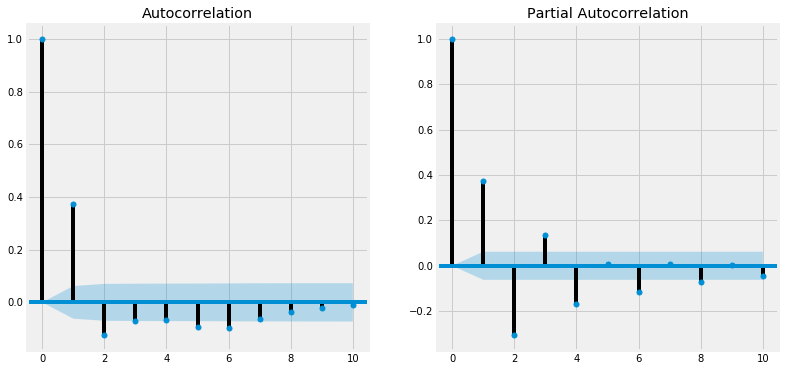

In [10]:
arma_model = sm.tsa.ARMA(y_sm, order=(1,0))

ests = arma_model.fit(maxiter=500, trend='nc')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sm.tsa.graphics.plot_acf(ests.resid, lags=10, ax=axes[0])
sm.tsa.graphics.plot_pacf(ests.resid, lags=10, ax=axes[1])
ests.summary()